# Análise Diagnóstica do preço do aluguel em São Paulo

**setup inicial**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
    
def f_format(df):
    print("linhas: ", df.shape[0], " colunas: ", df.shape[1])
    print("colunas do dataframe: ", list(df.columns))
    

def f_describe(df):
    print("primeiras 5 linhas do dataframe: ")
    display(df.head())
    print("\n")
    print("descrição estatística do dataframe: ")
    display(df.describe(include = "all"))

def f_values_check(df):
    print("tipos de dados: ")
    display(df.info())  
    print('\n')
    print("quantidades de valores ausentes por coluna: \n",df.isnull().sum())  
    print('\n')
    print("quantidades de valores infinitos: \n", np.isinf(df.select_dtypes(include=[np.number])).values.sum()) 
    print('\n')
    print("Possui ",df.duplicated().sum()," Duplicatas")


/kaggle/input/sao-paulo-housing-prices/data.csv


# Explorando o Dataset
Aqui vou analisar o dataset usando pandas

**Primeiro vou ler o csv e verificar as linhas e colunas**

In [2]:
df = pd.read_csv('/kaggle/input/sao-paulo-housing-prices/data.csv')
f_format(df)

linhas:  11657  colunas:  8
colunas do dataframe:  ['address', 'district', 'area', 'bedrooms', 'garage', 'type', 'rent', 'total']


**vendo o formato do df**

In [3]:
f_describe(df)

primeiras 5 linhas do dataframe: 


,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654




descrição estatística do dataframe: 


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,address,district,area,bedrooms,garage,type,rent,total
count,11657,11657,11657.000000,11657.000000,11657.000000,11657,11657.000000,11657.000000
unique,5348,1199,NaN,NaN,NaN,4,NaN,NaN
top,Rua da Consolação,Bela Vista,NaN,NaN,NaN,Apartamento,NaN,NaN
freq,49,352,NaN,NaN,NaN,7194,NaN,NaN
mean,NaN,NaN,84.655658,1.966286,1.060393,NaN,3250.814789,4080.030625
std,NaN,NaN,74.020536,0.931313,1.132349,NaN,2650.711557,3352.480274
min,NaN,NaN,0.000000,0.000000,0.000000,NaN,500.000000,509.000000
25%,NaN,NaN,40.000000,1.000000,0.000000,NaN,1590.000000,1996.000000
50%,NaN,NaN,60.000000,2.000000,1.000000,NaN,2415.000000,3057.000000
75%,NaN,NaN,96.000000,3.000000,2.000000,NaN,3800.000000,4774.000000


In [4]:
df['type'].unique()

array(['Studio e kitnet', 'Apartamento', 'Casa em condomínio', 'Casa'],
      dtype=object)

# Analisando o describe:


* Os 4 tipos são: kitnet, apartamento, casa_em_condominio e casa. 
* Média consideravelmente maior que a mediana e valores extremos no max de área, rent e total indicam uma distribuição com cauda a direita, portanto será necessário cuidar desses outliers.
* 0 não pode ser o mínimo de área (bedroom e garage podem).


quanto aos outliers será necessário:
* um limite inferior por regra de negócio para area
* limites superiores para area, bedrooms, garage e rent. Evitando, portanto a inclusão de imóveis de luxo.

# Manipulação do dataset
Será feita uma verificação e transformação do dataset para que possamos proseguir para a próxima etapa.

Abaixo vou verificar os **tipos de valores** e se há algum **valor nulo** ou **infinito** no dataset (mesmo que seja improvável). Vou verificar também por **duplicatas**.

In [5]:
f_values_check(df)

tipos de dados: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


None



quantidades de valores ausentes por coluna: 
 address     0
district    0
area        0
bedrooms    0
garage      0
type        0
rent        0
total       0
dtype: int64


quantidades de valores infinitos: 
 0


Possui  0  Duplicatas


**Tratamento de Outliers**

removendo outliers por regra de negócio:

In [6]:
regras_populares = {
    'Apartamento': {
        'area': (35, 80),
        'bedrooms': (1, 3),
        'garage': (0, 2),
        'rent': (1000, 6000)
    },
    'Casa': {
        'area': (30, 100),
        'bedrooms': (1, 4),
        'garage': (0, 2),
        'rent': (1000, 6000)
    },
    'Studio e kitnet': {
        'area': (15, 45),
        'bedrooms': (0, 1), 
        'garage': (0, 1),
        'rent': (1000, 3000)
    },
    'Casa em condomínio': {
        'area': (40, 90),
        'bedrooms': (1, 3),
        'garage': (0, 2),
        'rent': (1000, 6000)
    }
}

condicoes_por_tipo = []

for tipo, regras_do_tipo in regras_populares.items():
    # Condição para o tipo de imóvel atual
    condicao_tipo_imovel = (df["type"] == tipo)

    # Condições para os atributos (area, bedrooms, garage, rent)
    condicoes_atributos = []
    for atributo, (lim_inferior, lim_superior) in regras_do_tipo.items():
        condicoes_atributos.append(
            (df[atributo] >= lim_inferior) & (df[atributo] <= lim_superior)
        )

    from functools import reduce
    condicao_atributos_combinada = reduce(lambda x, y: x & y, condicoes_atributos)

    condicao_final_para_este_tipo = condicao_tipo_imovel & condicao_atributos_combinada
    condicoes_por_tipo.append(condicao_final_para_este_tipo)

filtro_final = reduce(lambda x, y: x | y, condicoes_por_tipo)

df_limpo = df[filtro_final]

print(f"Antes: {df.shape[0]} linhas")
print(f"Removidas: {df.shape[0] - df_limpo.shape[0]} linhas")
print(f"Depois: {df_limpo.shape[0]} linhas")

df_limpo = df_limpo.drop(columns = 'rent')
df_transformado = df_limpo

Antes: 11657 linhas
Removidas: 5113 linhas
Depois: 6544 linhas


In [7]:
f_format(df_limpo)

linhas:  6544  colunas:  7
colunas do dataframe:  ['address', 'district', 'area', 'bedrooms', 'garage', 'type', 'total']


In [8]:
f_describe(df_limpo)

primeiras 5 linhas do dataframe: 


,address,district,area,bedrooms,garage,type,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1345
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1954
5,Rua Domingos Paiva,Brás,50,2,1,Apartamento,4587
6,Rua Guararapes,Brooklin Paulista,72,2,1,Apartamento,5187




descrição estatística do dataframe: 


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,address,district,area,bedrooms,garage,type,total
count,6544,6544,6544.000000,6544.000000,6544.000000,6544,6544.000000
unique,3349,977,NaN,NaN,NaN,4,NaN
top,Rua da Consolação,Bela Vista,NaN,NaN,NaN,Apartamento,NaN
freq,26,241,NaN,NaN,NaN,4583,NaN
mean,NaN,NaN,53.566779,1.692696,0.689792,NaN,2839.307610
std,NaN,NaN,16.681373,0.642026,0.617672,NaN,1279.848386
min,NaN,NaN,15.000000,0.000000,0.000000,NaN,1013.000000
25%,NaN,NaN,40.000000,1.000000,0.000000,NaN,1873.750000
50%,NaN,NaN,52.000000,2.000000,1.000000,NaN,2557.000000
75%,NaN,NaN,65.000000,2.000000,1.000000,NaN,3508.000000


# Enriquecimento dos dados

* o total será substituido pelo preço por metro quadrado.

* o type será transformado com one-hot encoding para analisar cada tipo separadamente.

* o distric e address vão ser usados para categorização por preço médio da região e vou criar rótulos com 5 categorias sendo 0 áreas com a média do m² barata e 5 as mais caras.


In [9]:
#reformulação do total

df_transformado.total = round(df_limpo.total / df_limpo.area, 2)
df_transformado.rename(columns={'total': 'cost/m²'}, inplace = 'true')

In [10]:
df_dummies = pd.get_dummies(df_transformado['type'], prefix='type')
df_transformado = pd.concat([df_transformado, df_dummies], axis=1)
boolean_columns = df_dummies.columns

for col in boolean_columns:
    df_transformado[col] = df_transformado[col].astype(int)


In [11]:
if 'address'in df_transformado.columns and 'district' in df_transformado.columns:
    media_por_endereço = df_transformado.groupby('district')['cost/m²'].mean().reset_index()
    media_por_endereço.columns = ['district', 'avg_price_per_m2']
    media_por_endereço['valor_regiao'] = pd.cut(media_por_endereço['avg_price_per_m2'],bins=5,labels=[1,2,3,4,5],
    include_lowest=True)
    df_transformado = df_transformado.merge(media_por_endereço[['district', 'valor_regiao']], on='district', how='left')
    df_transformado = df_transformado.drop(columns = ['address', 'district'])
    df_transformado['valor_regiao'] = df_transformado['valor_regiao'].astype(int)

In [12]:
f_describe(df_transformado)

primeiras 5 linhas do dataframe: 


,area,bedrooms,garage,type,cost/m²,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet,valor_regiao
0,21,1,0,Studio e kitnet,139.95,0,0,0,1,3
1,15,1,1,Studio e kitnet,89.67,0,0,0,1,2
2,56,2,2,Casa em condomínio,34.89,0,0,1,0,1
3,50,2,1,Apartamento,91.74,1,0,0,0,2
4,72,2,1,Apartamento,72.04,1,0,0,0,3




descrição estatística do dataframe: 


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,area,bedrooms,garage,type,cost/m²,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet,valor_regiao
count,6544.000000,6544.000000,6544.000000,6544,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000
unique,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Apartamento,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,4583,NaN,NaN,NaN,NaN,NaN,NaN
mean,53.566779,1.692696,0.689792,NaN,56.583029,0.700336,0.154493,0.014364,0.130807,2.294315
std,16.681373,0.642026,0.617672,NaN,27.397448,0.458146,0.361448,0.118996,0.337215,0.831258
min,15.000000,0.000000,0.000000,NaN,11.790000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,40.000000,1.000000,0.000000,NaN,37.430000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,52.000000,2.000000,1.000000,NaN,49.885000,1.000000,0.000000,0.000000,0.000000,2.000000
75%,65.000000,2.000000,1.000000,NaN,69.372500,1.000000,0.000000,0.000000,0.000000,3.000000


# Análise exploratória dos dados limpos

gráficos para EDA

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


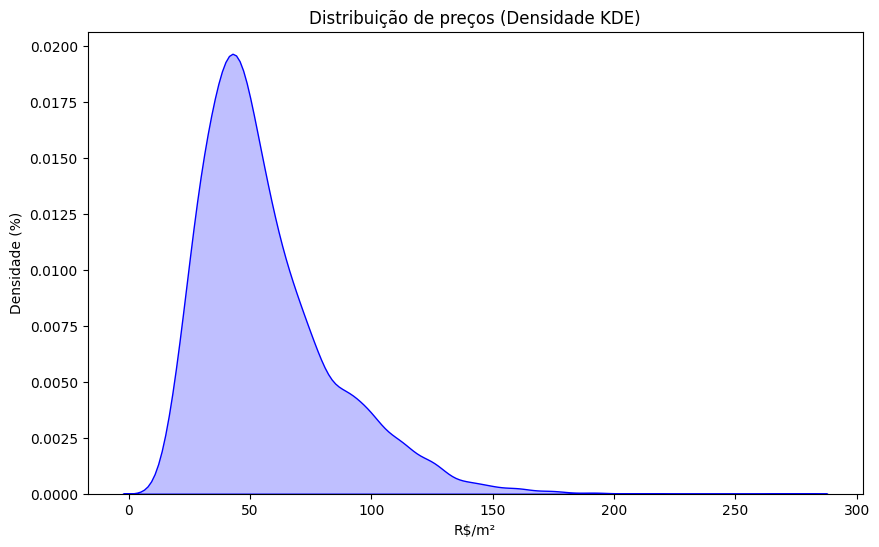

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


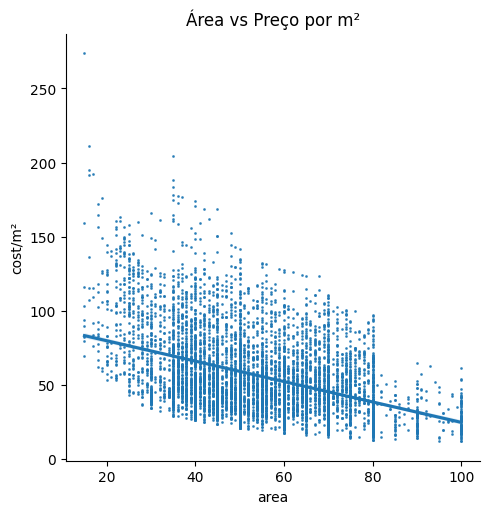

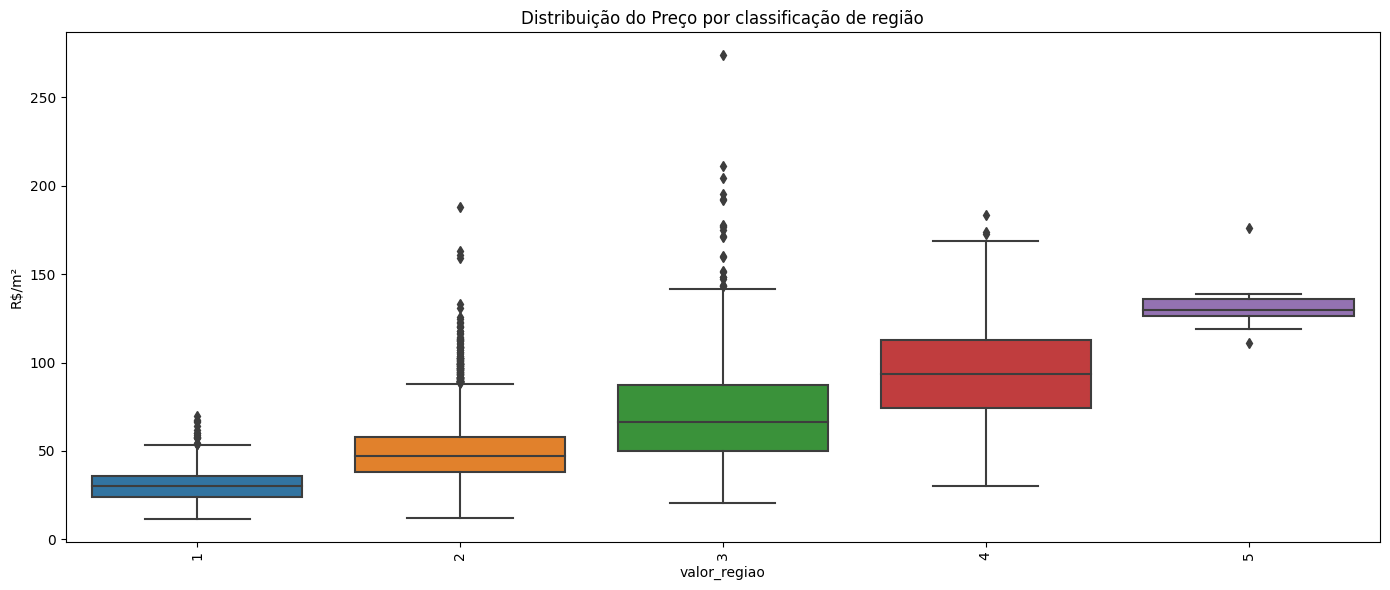

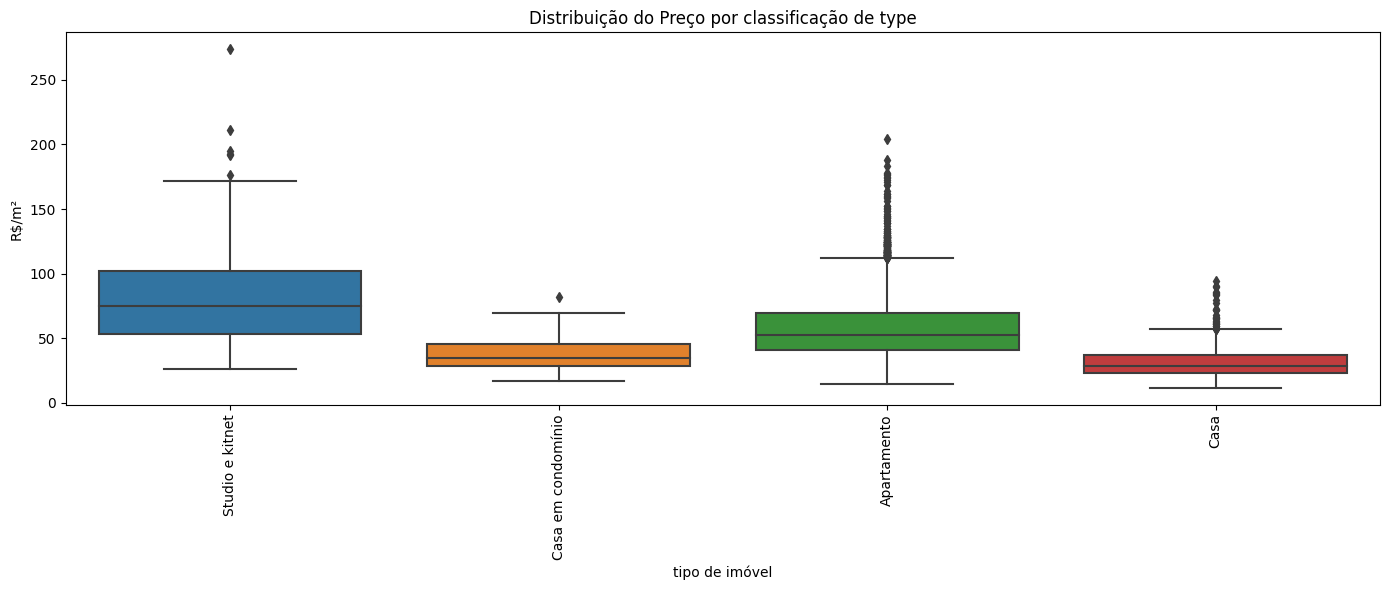

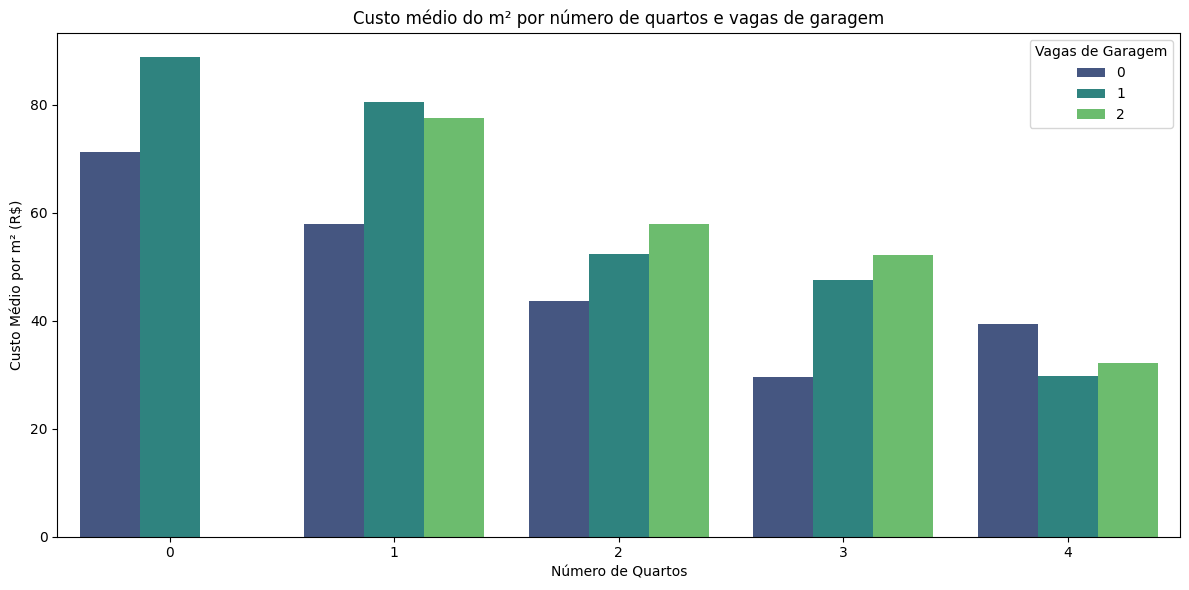

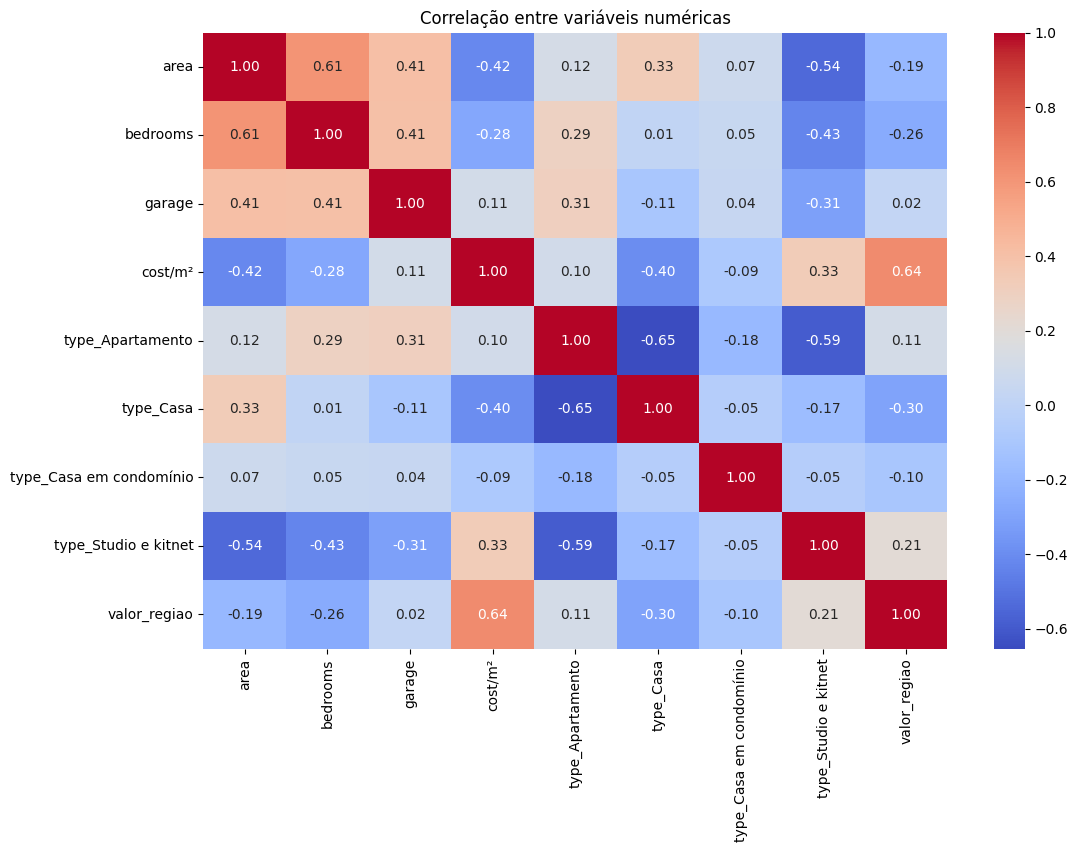

In [13]:

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_transformado, x='cost/m²', fill=True, color='blue')
plt.title("Distribuição de preços (Densidade KDE)")
plt.xlabel("R$/m²")
plt.ylabel("Densidade (%)")
plt.show()

sns.lmplot(data=df_transformado, x='area', y='cost/m²', scatter_kws={'s': 1})
plt.title("Área vs Preço por m²")
plt.show()


plt.figure(figsize=(14, 6))
sns.boxplot(data=df_transformado, x='valor_regiao', y='cost/m²')
plt.xticks(rotation=90)
plt.title('Distribuição do Preço por classificação de região')
plt.ylabel('R$/m²')
plt.xlabel('valor_regiao')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_transformado, x='type', y='cost/m²')
plt.xticks(rotation=90)
plt.title('Distribuição do Preço por classificação de type')
plt.ylabel('R$/m²')
plt.xlabel('tipo de imóvel')
plt.tight_layout()
plt.show()


grouped = df_transformado.groupby(['bedrooms', 'garage'])['cost/m²'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(data=grouped, x='bedrooms', y='cost/m²', hue='garage', palette='viridis')
plt.title('Custo médio do m² por número de quartos e vagas de garagem')
plt.xlabel('Número de Quartos')
plt.ylabel('Custo Médio por m² (R$)')
plt.legend(title='Vagas de Garagem')
plt.tight_layout()
plt.show()


df_numerico = df_transformado.select_dtypes(include='number')
plt.figure(figsize=(12,8))
sns.heatmap(df_numerico.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlação entre variáveis numéricas")
plt.show()
#todos os p-values para 'cost/m²' indicam correlação forte.

Hipóteses ordem de influência:
* o valor da região é o fator mais fortemente relacionado pois se relaciona com a criminalidade, proximidade de comércio, metrô, entre outros fatores derivados da geolocalização. (confirmada)
* o preço por metro quadrado é inversamente proporcional a area. (confirmada)
* quanto mais quartos menos costuma se pagar por metro quadrado (confirmada)
* quanto mais garagens mais caro costuma se pagar por metro quadrado (confirmada)
* quando se trata de preço médio por metro quadrado no aluguel: casa < casa em condomínio < apartamento < studio e kitnet (confirmada)

# Machine learning para modelagem preditiva

Aqui aplico machine learning para testar as hipóteses descobrindo as features mais relevantes e criando um modelo de predição para o target (cost/m²)
Talvez com outras features derivadas da localização, como proximidade do metrô, criminalidade ou mesmo classificação de pagar ou não pagar condomínio uma análise mais rica pudesse ser feita (R² seria maior).
Utilizei todas as features para regressão do custo, usei cross-validation e um pipeline básico de normalização e modelo (GradientBoostingRegressor). Obtive R² = 64%

Separando as features da predição e fazendo o split do dataset entre treino e teste.

In [14]:
X = df_transformado[['area','bedrooms', 'garage', 'valor_regiao','type_Apartamento', 'type_Casa','type_Casa em condomínio',	'type_Studio e kitnet']].astype(float)
Y = df_transformado['cost/m²']
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


aplicando e avaliando o modelo random forest regressor

In [15]:
gb_model = GradientBoostingRegressor()
Input=[('scale',StandardScaler()), ('model',gb_model)]
pipe = Pipeline(Input)
resultados = cross_val_score(pipe, X, Y, cv=kfold, scoring='r2') 
print("R² por fold:", resultados)
print("Média R²:", np.mean(resultados))
print("Desvio padrão:", np.std(resultados))

R² por fold: [0.664247   0.635748   0.65606714 0.5992549  0.66663345]
Média R²: 0.644390100720145
Desvio padrão: 0.02504910448075722


Com a análise exploratória inicial eu consegui tirar insights para a limpeza e transformação dos dados.
Com a análise exploratória depois do tratamento consegui observar o que ocorreu (análise descritiva).

Aqui está então uma formulação de análise diagnóstica de como as features análisadas no dataset utiizado podem ter influencia, e não apenas correlação, com o preço (R$) da área (m²) do aluguel no estado de São Paulo:
* o valor da região (média do custo do metro quadrado por bairro classificada de 1 a 5) é o fator mais determinante pois se relaciona com a criminalidade, densidade comercial, metrô, entre outros fatores derivados da geolocalização e que em São Paulo tendem a ser fatores importantes na decisão de qual imóvel escolher já que o estado é muito urbanizado portanto possui uma variação ampla por bairro. 
* quanto mais área determinado imóvel possui, menos liquidez ele tem, portanto a area tende a perder valor e o custo do m² por mês diminui.
* quanto mais quartos menos costuma se pagar por metro quadrado, provavelmente por um comportamento semelhante ao ponto anterior.
* quanto mais garagens mais caro costuma se pagar por metro quadrado. Isso ocorre porque em uma área altamente urbanizada a segurança de um bem como o carro é alta prioridade, valorizando a área do imóvel.
* quando se trata de preço médio por metro quadrado no aluguel: casa < casa em condomínio < apartamento < studio e kitnet. Os studios/kitnet e apartamentos costumam ser mais bem localizados (fator de encarecimento) - studio e kitnet costuma ser mais caro pois sua área é menor. Todos os tipos de imóvel, exceto a Casa, pagam condomínio e de certa forma costumam ter um critério de localização mais rigoroso para sua construção e aluguel, por isso a casa costuma ser o tipo mais barato.

Além disso com o modelo de regressão e as features do dataset é possível fazer predição do custo do metro quadrado (análise preditiva) e assim auxiliar na tomada de decisões (análise prescritiva) estabelecendo uma ordem de escolhas baseadas na prioridade de negócio e em dados.



In [16]:
df_output = df_transformado

# Exportando os dados
exportando os dados pós mineração para elaborar um dashboard e uma apresentação clara sobre os dados em relação ao negócio (mercado imobiliário de aluguel em São Paulo).
O objetivo é responder quais, como, e porque (com análise de BI), os fatores mais determinantes no preço do m²/mês em São Paulo, realizando assim uma análise diagnostica que pode ser usada para predição e prescrição em outros casos.

In [17]:
f_describe(df_output)

primeiras 5 linhas do dataframe: 


,area,bedrooms,garage,type,cost/m²,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet,valor_regiao
0,21,1,0,Studio e kitnet,139.95,0,0,0,1,3
1,15,1,1,Studio e kitnet,89.67,0,0,0,1,2
2,56,2,2,Casa em condomínio,34.89,0,0,1,0,1
3,50,2,1,Apartamento,91.74,1,0,0,0,2
4,72,2,1,Apartamento,72.04,1,0,0,0,3




descrição estatística do dataframe: 


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,area,bedrooms,garage,type,cost/m²,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet,valor_regiao
count,6544.000000,6544.000000,6544.000000,6544,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000
unique,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Apartamento,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,4583,NaN,NaN,NaN,NaN,NaN,NaN
mean,53.566779,1.692696,0.689792,NaN,56.583029,0.700336,0.154493,0.014364,0.130807,2.294315
std,16.681373,0.642026,0.617672,NaN,27.397448,0.458146,0.361448,0.118996,0.337215,0.831258
min,15.000000,0.000000,0.000000,NaN,11.790000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,40.000000,1.000000,0.000000,NaN,37.430000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,52.000000,2.000000,1.000000,NaN,49.885000,1.000000,0.000000,0.000000,0.000000,2.000000
75%,65.000000,2.000000,1.000000,NaN,69.372500,1.000000,0.000000,0.000000,0.000000,3.000000


In [18]:
df_output.columns = ['área (m²)', 'quartos', 'vagas de garagem', 'tipo de imóvel', 'custo (R$/m²)', 'type_Apartamento', 'type_Casa', 'type_Casa em condomínio', 'type_Studio e kitnet', 'valor da região' ]

mapeamento = {
    1: 'Muito barata',
    2: 'Barata',
    3: 'Média',
    4: 'Cara',
    5: 'Muito cara'
}

df_output['valor da região'] = df_output['valor da região'].map(mapeamento)
df_output.drop(columns = ['type_Apartamento', 'type_Casa', 'type_Casa em condomínio', 'type_Studio e kitnet'], inplace = True)
df_output['área (m²)']=df_output['área (m²)'].astype(float)

In [19]:
f_values_check(df_output)
f_describe(df_output)

tipos de dados: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6544 entries, 0 to 6543
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   área (m²)         6544 non-null   float64
 1   quartos           6544 non-null   int64  
 2   vagas de garagem  6544 non-null   int64  
 3   tipo de imóvel    6544 non-null   object 
 4   custo (R$/m²)     6544 non-null   float64
 5   valor da região   6544 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 306.9+ KB


None



quantidades de valores ausentes por coluna: 
 área (m²)           0
quartos             0
vagas de garagem    0
tipo de imóvel      0
custo (R$/m²)       0
valor da região     0
dtype: int64


quantidades de valores infinitos: 
 0


Possui  48  Duplicatas
primeiras 5 linhas do dataframe: 


,área (m²),quartos,vagas de garagem,tipo de imóvel,custo (R$/m²),valor da região
0,21.0,1,0,Studio e kitnet,139.95,Média
1,15.0,1,1,Studio e kitnet,89.67,Barata
2,56.0,2,2,Casa em condomínio,34.89,Muito barata
3,50.0,2,1,Apartamento,91.74,Barata
4,72.0,2,1,Apartamento,72.04,Média




descrição estatística do dataframe: 


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,área (m²),quartos,vagas de garagem,tipo de imóvel,custo (R$/m²),valor da região
count,6544.000000,6544.000000,6544.000000,6544,6544.000000,6544
unique,NaN,NaN,NaN,4,NaN,5
top,NaN,NaN,NaN,Apartamento,NaN,Barata
freq,NaN,NaN,NaN,4583,NaN,3354
mean,53.566779,1.692696,0.689792,NaN,56.583029,NaN
std,16.681373,0.642026,0.617672,NaN,27.397448,NaN
min,15.000000,0.000000,0.000000,NaN,11.790000,NaN
25%,40.000000,1.000000,0.000000,NaN,37.430000,NaN
50%,52.000000,2.000000,1.000000,NaN,49.885000,NaN
75%,65.000000,2.000000,1.000000,NaN,69.372500,NaN


In [20]:
df_output.to_csv('sp_housing_data_output.csv', index=False, encoding='utf-8-sig')

# Comentários finais sobre o projeto
Possíveis melhorias:
* integração entre as etapas de coleta, tranformação e visualização de dados, possivelmente usando uma base diferente ou webscraping neste jupyter notebook aumentando a confiabilidade dos dados. Também seria interessante usar um banco de dados e API para criação do dashboard, dessa forma este também seria atualizado em tempo real.

Insights:
Todo o processo de dados tem como objetivo extrair conhecimento e enriquecer a sabedoria de negócio, mas para isso cada etapa é crucial, é necessário muita cautela e revisões para garantir um fluxo de trabalho o mais linear possível evitando retomadas para etapas anteriores. 
Além disso, o processo de dados sempre pode ter seu valor aumentado.
Quanto mais próxima da arquitetura do processo e mais distante da análise final, mais crítica é a etapa, pois erros na base tendem a ser notados só posteriormente encarecendo suas correções.
